<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/super-opt-perturb/sequences/P2C1_CurveFitting/P2C1_Sequence1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.1: Curve Fitting Through Perturbation**
In the first part of the book we gained insight into what the brain is for: rapid acquisition of adaptive behaviours. Now that we know what a brain is for we are going to start thinking about how it does what it needs to do. Instead of taking a bottom up approach grounded in observed physiological mechanisms, we are going to use a problem oriented, top down approach. That is, we will think about what problems the brain is solving and then survey the various physiological mechanisms that could feasibly implement algorithms that solve those problems. We will start with problems that are simple to understand from a statistical and mathematical perspective; a broad sub-field of machine learning known as supervised learning. Supervised learning problems presuppose many features without clear physiological counterparts in the brain. Nevertheless, for simplicity and to build foundational understanding we start this class of problems and associated alogorithimg, drawing connections to physiological mechanisms where we can. As more elaborate learning algorithms (un/semi-supervised learning, complex reinforcement learning) and their applications become clear, we promise that an outline of the physiology of a unified neural system which feasibly solves the myriad statistical decision problems faced by living animals will emerge.

### Objective: Solve a simple problem using perturbation methods, and connect these methods with physiological neural plasticity mechanisms.

In this sequence we will:

* Introduce two visual (binary) discrimination task, one very simple, one slightly more complex

* Build and train a simple 'neural circuit' model which 'learns' to solve these binary discrimination problems based on scalar reward feedback.

* Relate the different aspect of our simple 'neural circuit' model to different neural plasticity mechanisms.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S1"

Best feature is 21
Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.1.1: Learning to Do The Right Thing

In our last chapter on evolution, we motivated much of our modeling using a binary classification problem in which a lurking predator most choose between striking and not striking based on sensory input. Initially, we viewed the behavioral map from sensory input to action as genetically determined. However, we concluded the last chapter by highlighting the evolutionary advantage of (at least partially) learning these sensory-behaviour maps within an organism's lifetime. (These advantages emerge in part due to variable environments and complex behaviors with non-linear fitness impacts.) Here we shift our focus, and work with the case where the behavioural map from sensory input to action is to be entirely 'learned' by the organism, using feedback signals from the environment. Before we built a highly abstracted model of a neural circuit to solve this problem, let's test if your neural network is up to the task. Given a sensory input pattern, determine whether to strike or not. Try to maximize your average score and see how well you can perform. We will start with a very simple 'sensory' pattern.

In [2]:
class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # intialize game state
    self.current_index = 0
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    board_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    self.ui = widgets.HBox([board_buttons, widgets.VBox([self.score_display,
                                                         self.feedback_display])])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]
    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    # Display the image
    #print(image)
    self.fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.ax.axis('off')
    self.ax.imshow(image, cmap='gray', vmin=-6, vmax=6)
    self.fig.canvas.draw_idle()  # Force redraw

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_01_imp = InteractiveMNISTPredator(features=X_simple_1_feature,
                                           labels=y1_simple, feedback_type='both')
display(scramble_01_imp.fig.canvas)
clear_output()
display(scramble_01_imp.ui)

For us at least, this task wasn't too hard, the simple association, strike when the center pixels are relatively light, don't strike when the center pixels are dark works well. We can learn this association with our eyes and brains, now let's see if we can come up with a way to program an algorithm that will also learn this association. The data set that underlies this strike-no-strike decision problem comes from the UCI Machine Learning Repository (Alpaydin,E. and Kaynak,C. (1998). https://doi.org/10.24432/C50P49.) Let's take a quick look at the data before we start coming up with a simple machine learning algorithm to correctly separate the cases when we should strike from when we should not.

In [3]:
# What is the shape and type of the data we have to work with
print(f'features data type: {X_simple_1_feature.dtype}')
print(f'features shape: {X_simple_1_feature.shape}')
print(f'labels data type: {y1_simple.dtype}')
print(f'labels shape: {y1_simple.shape}')

features data type: float64
features shape: (1125, 1)
labels data type: int64
labels shape: (1125, 1)


In [4]:
# what do the labels look like, what is their range
print(y1_simple[:10])
print(f'max label: {np.max(y1_simple)}')
print(f'min label: {np.min(y1_simple)}')

[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]
max label: 1
min label: 0


**Note on Terminology:** In a Supervised Learning context **features** are the inputs to a sensory-behaviour circuit. In a statistical/regression/experimental context these features or inputs are thought of as the independent variables or regressors. The 'correct' behavioural output is called the **label** or **target** in a supervised learning ML context, or the dependent variable in a statistical/regression/experimentat. Supervised Learning revolves around the concept of feature/label or $(\mathbf{x},\mathbf{y})$ pairs, with the basic goal of supervised learning being to discover the rule or process which generates these pairs (or a good approximation of it), just from examining examples. The set of examples that we have to learn the rule from is called the **training set**. We will use the terms features and label when we want emphasize the abstract algorithm and learning problem, and sensory-input and target behaviour when we want to emphasize the embodied neural context of the problem.

In the game we setup above we used the label '1' to correspond to situations when 'strike' is the correct action and the label '0' to correspond to situations where 'no-strike' is the correct action.

In [5]:
# what do the features look like, what is there range
print(X_simple_1_feature[:10])
print(f'max features: {np.max(X_simple_1_feature)}')
print(f'min features: {np.min(X_simple_1_feature)}')

[[-6. ]
 [-6. ]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 4.5]
 [-6. ]
 [ 6. ]
 [-6. ]
 [ 6. ]]
max features: 6.0
min features: -6.0


In the visualization above a high 'feature value' corresponded to lighter colors in the center pixels and a lower feature value corresponded to darker feature values.

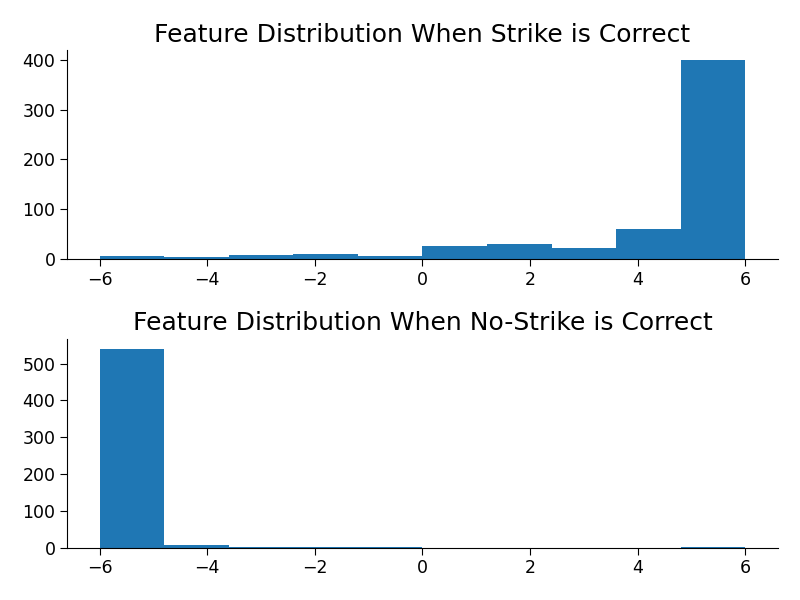

In [6]:
# and for scalar data always good to look at a histogram
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(X_simple_1_feature[y1_simple.flatten() == 1])
ax1.set_title('Feature Distribution When Strike is Correct')
ax2.hist(X_simple_1_feature[y1_simple.flatten() == 0])
ax2.set_title('Feature Distribution When No-Strike is Correct')
plt.show()

Looking at the distribution of the feature across these two classes (strike vs. no-strike situations) we see that we should be able to correctly discriminate between these two cases most of the time using just this one feature.

Now, if we were acting as scientist (which we sometimes do!), we'd think hard and carefully about the specific physical processes behind these features (the ML term for model/sensory inputs) and labels (the ML term for 'correct answer'), and this would guide the types of analyses to perform on the data and the kinds of inferences and conclusions we could draw.
But in this moment, we're not acting as scientists in pursuit of deep understanding; we're acting as algorithm designers focused on figuring out how to do the right thing. We want come up with a process for 'learning a function' that takes this feature as an input and generates the correct behaviour (as defined by the labels) as a behavioural outputs. A zero label means no strike is the right thing to do (no prey present) and a one label means striking is the right thing to do (prey are present).  

As inspiration for our learning algorithm we imagine a very simple organism. One that has a signle sensory input neuron, in turn connected to a single output neuron by single synaptic weight. If the output neuron fires (spikes) the predator strikes, and if it does not fire the predator does not strike.

We model this creature's sensory-behaviour system as follows. Let $x$ be the raw sensory input (scalar) in a given episode. We imagine that $x$ corresponds to the activation level and firing rate of a single photosensitive neuron. This input neuron is then connected by a synapse to a single output neuron. The activation level of this output neuron is computed as
$$y = wx + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $w$ is the strength of the synaptic weight between the input neuron and the output neuron (is this case there is only one output and one input so $w$ is a scalar, in cases with multiple inputs and outputs we would use $\mathbf{W}$ to denote the matrix of such synaptic weights and $\mathbf{x}$ to denote the vector of sensory inputs. As a quick reminder, in our notation, bold lowercase letters represent column vectors, while bold uppercase letters denote matrices or higher-dimensional tensors.)  We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

--Picture of this very simple neural circuit here--

**Quick Math Exercise**

Consider a random variable with two possible outcomes, $A$ and $B$. The probability of each outcome is determined by applying the softmax function to their respective scores, $a$ and $b$. Specifically, the probability of outcome $A$ occurring is given by the softmax formula:
$$ \Pr \{A\} = \frac{e^a}{e^a + e^b}$$
Interestingly, $\Pr{A}$ can be expressed in terms of the logistic (sigmoid) function, $\sigma(x)$, where $x$ is a function of the scores $a$ and $b$. Your task is to determine this function, denoted as $f(a, b)$, so that $\Pr{A} = \sigma(f(a, b))$.


Having established how behaviour is determined by sensory input, $x$, and parameters $w$, $b$, i.e. our policy, we now need to develop a rule for modifying this policy based on environmental feedback.

Our goal is to come up with a rule that prescribes changes to the synaptic weight $w$ and bias $b$ in such a way that the reward obtained over time increases (and ideally approaches the theoretical maximum over many learning trials).

Our previous 'guess and check' learning method from sequence 1.3.4, while not the most efficient, proved effective, as was the 'propose and reject' style algorithms that we explored earlier and that are akin to what evolution by natural selection implements. Building on this idea of 'propose and reject' we will perturb the existing weights by a small amount, evaluate the behaviour function using the perturbed weights. However, instead of just simply accepting or rejecting the proposed parameters (kind of like natural selection does) we will instead ***measure the relationship between the change in the performance of the the organism (in terms of reward obtained) and the changes in the parameters.*** An update will then be applied to the weights that is ***proportional*** to the ***measured performance changes*** over the ***measured parameter changes***, i.e. an estimate of the rate of change in performance for changes in the parameters. As a word equation

$$ \text{Parameter Update} = \alpha \cdot \frac{\text{Measured Perturbation in Performance}}{\text{Measured Perturbation in Parameters}}$$

where $\alpha$ is some constant of proportionality, in this case usually called the learning rate or step-size meta-parameter of the learning algorithm.

On the one hand we might expect a 'measure and update' method to be more efficient than a 'propose and reject' method, because with a 'propose and reject' alogorithm we don't make any parameter updates unless 'better' parameters are proposed. This means that most of the information from evaluation is thrown away every time parameters are rejected. In contrast, a 'measure and update' method will always updated the parameters using the information gleaned from the tested parameters. However, unlike the 'propose and reject' algorithm it's possible that the updates made by a 'measure and update' approach do not actually improve performance.

Let's try it and see.

In [7]:
################################################################################
# TODO for students: Complete the lines with ... to implement a parameter
# evalution function
raise NotImplementedError("Exercise: parameter evaluation")
################################################################################


def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg


NotImplementedError: Exercise: parameter evaluation

In [8]:
# to_remove solution

def np_sigmoid(x):
  return 1 / (1 + np.exp(-x))


def eval_params_slow(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use for loops to think carefully about what we're doing
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (1 np.array x batch) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (1 np.array x batch) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  batch_len = x.shape[1]
  h = np.zeros((1, batch_len))
  y_hat = np.zeros((1, batch_len))
  R_total = 0
  for ii in range(batch_len):
    h[0,ii] = w * x[0,ii] + b
    y_hat[0,ii] = np_sigmoid(h[0,ii])
    # y_hat is our probability of striking
    # compute the expected score
    if y[0,ii] == 1:
      # supposed to strike
      # with probability y_hat creature strikes and gets a point
      R_total += y_hat[0,ii] * 1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    elif y[0,ii] == 0:
      # not supposed to strike
      # with probability y_hat creature strikes and loses a point
      R_total += y_hat[0,ii] * -1.0
      # with probability 1-y_hat creature doesn't strike and gets zero points
      R_total += (1-y_hat[0,ii]) * 0.0
    else:
      raise ValueError(f'Unexpected target: {y[ii,0]}')
  R_avg = R_total / batch_len
  return R_avg


def eval_params(w, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    w: (scalar) weight between sensory and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (batch x 1 np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (batch x 1 np.array) target behavioural output (can be a single target,
       mini-batch of targets, or whole batch), needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = w * x + b
  y_hat = np_sigmoid(h)
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_avg = np.mean(batch_expected_reward)
  return R_avg


In this exercise we actually implemented the same function twice, once using a for loop to iterate over the (mini-)batch of inputs and targets, and once using numpy broadcasting to compute the batch reward (roughly) in parallel. Run the following code cells to see what kind of computational efficiency this buys us.

In [9]:
X_simple_1_feature.T.shape

(1, 1125)

In [10]:
eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

0.46215956306090394

In [11]:
eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

0.4621595630608997

In [12]:
%timeit eval_params_slow(1, 0, X_simple_1_feature.T, y1_simple.T)

4.01 ms ± 512 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit eval_params(1, 0, X_simple_1_feature.T, y1_simple.T)

51.6 µs ± 807 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In our specific example (on the specific COLAB instance we're writing this on in 2024), the broadcasting approach in Python, using NumPy, is approximately 50 times faster than using for-loops. This is because for-loops in interpreted languages like Python incur significant overhead at each iteration, in part due to potential dependencies between loop iterations which limit parallelization. In contrast, broadcasting allows for vectorized operations, enabling parallel execution that can harness more of the underlying hardware's computational power. NumPy enhances this efficiency further by utilizing highly optimized, pre-compiled linear algebra libraries (primarily hardware-specific implementations of BLAS and LAPACK). The same principles apply (though are sometimes less critical) in compiled languages or with Just-In-Time (JIT) compilation frameworks like JAX. Broadcasting or tensor notation not only improves performance but also maintains code brevity and alignment with mathematical notation. As scientists and programmers, we do not need to understand every detail of how the magic of computational parallelism allows for fast linear algebra, but it is crucial to appreciate the potential impacts on computational efficiency.

Okay so we have the ability to evaluate the parameters in terms of the average score the yeild when applied across the whole 'data set' of examples we have of senory inputs and correct actions. Let's start with 'neutral' parameters $w=0$ and $b=0$, which gives a fifty-fifty chance of striking or not-striking regardless of input. Then, in each iteration of our learning (training) loop we will perturb our parameters using Gaussian noise and ***measure the relationship*** between the parameter changes and the average expected reward as determined by our evalutation function. After measuring this relationship, we will update each parameter in proportion to the rate of improvement of the score with resepct to the change in the underlying parameter.

In [14]:
# @title Measure and Update Training Loop

learn_rng = np.random.default_rng(0)
num_learning_episodes = 100000
alpha = 200 #learning rate / step size
perturbation_scale = 0.1 # std of guassian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_perturbed = w + w_perturbation
  R_bar_perturbed_w = eval_params(w_perturbed, b, X_simple_1_feature.T, y1_simple.T)
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params(w, b_perturbed, X_simple_1_feature, y1_simple)
  # estimate rate of change of reward for each parameter
  finite_difference_w = (R_bar_perturbed_w - R_bar_old) / w_perturbation
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_w = alpha * finite_difference_w
  delta_b = alpha * finite_difference_b
  w += delta_w
  b += delta_b

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

   Iteration: 0      | w=5.5287   | b=2.4765   | R_bar=0.462160 | Time=0.00  seconds
   Iteration: 5000   | w=12.5186  | b=42.2319  | R_bar=0.495022 | Time=0.83  seconds
   Iteration: 10000  | w=14.3977  | b=48.6602  | R_bar=0.495067 | Time=1.65  seconds
   Iteration: 15000  | w=15.5291  | b=52.3596  | R_bar=0.495082 | Time=2.48  seconds
   Iteration: 20000  | w=16.2992  | b=55.0076  | R_bar=0.495089 | Time=3.30  seconds
   Iteration: 25000  | w=16.8975  | b=57.0190  | R_bar=0.495094 | Time=4.12  seconds
   Iteration: 30000  | w=17.3875  | b=58.6933  | R_bar=0.495097 | Time=4.94  seconds
   Iteration: 35000  | w=17.8059  | b=60.0948  | R_bar=0.495099 | Time=5.75  seconds
   Iteration: 40000  | w=18.1838  | b=61.3382  | R_bar=0.495100 | Time=6.59  seconds
   Iteration: 45000  | w=18.4996  | b=62.4001  | R_bar=0.495102 | Time=7.40  seconds
   Iteration: 50000  | w=18.7787  | b=63.3663  | R_bar=0.495103 | Time=8.23  seconds
   Iteration: 55000  | w=19.0346  | b=64.2503  | R_bar=0.495103 |

Is an R_bar of 0.4951... good or bad? Let's look at the data. How many striking opportunities are there, versus situation where no-strike is best?

In [15]:
# number of striking opportunities
np.sum(y1_simple == 1)

571

In [16]:
#number of non-strike situations
np.sum(y1_simple == 0)

554

In [17]:
# proportion of situations where a point can be earned
571 / (571 + 554)

0.5075555555555555

So, back to our question: Is an average score of 0.4951... per round good? Well, yes. A perfect score is 0.5075..., and given that we only have this one feature to work with - a feature that can't perfectly separate the two cases (as the distributions overlap a bit) - we are bound to have a few false positives and false negatives. These will lower the score a bit, but for the most part, this is roughly as good as can be expected.

**Algorithmic Thinking Exercise:**

In the 'measure and update' learning loop implemented above we perturb each parameter, measure the effect of perturbations, and then update the parameters. Alternatively we could have perturbed the $w$ parameter, evaluated and then updated the $w$ parameter, and then perturbed the $b$ parameter, evaluated, and then updated the $b$ parameter.
1. In the implementation above how many times is the `eval_params` function called per iteration?

  (Answer: 3)
2. If we used the alternative where each parameter is updated and after evaulation, how many times would`eval_params` need to be called per iteration?

  (Answer: 4, After updating $w$ we can't simply use `R_bar_old` to measure the change in performance from changing $b$ since `R_bar_perturbed_b` will be computed using the updated $w$. An `R_bar_new_w_old_b` will need to be computed and used to inform the changes to $b$.)
3. If we had $n$ parameters instead of 2, how many times would the `eval_params` function be called per iteration in the implementation above?

  (Answer: $n+1$)
4. If we had $n$ parameters and instead of 2, how many times would the `eval_params` function be called per iteration in the alternate implementation?

  (Answer: $2n$)

Little details like this in implementation can make big differences to algorithm speed. Note though that this slower alternative isn't quite a dead loss. Technically the parameter updates made by the alternative algorithm, will be 'better' (precisely what we mean by better we leave aside for the moment), however, in this particular case the 'betterness' of the parameter updates is not enough to make up for the added computational cost of calling `eval_params` and extra $n-1$ times.

Okay, now just as a sanity and intuition check, two questions:
1. Do we get the same answer when we use a propose and reject method?  
2. Is the propose and reject method quicker or slower at finding the solution?
Let's quickly adapt the adapt 'measure and update' learning loop to do 'propose and reject' instead.

In [18]:
# @title Propose And Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 50000
perturbation_scale = 0.1 # std of guassian parameter perturbations
w_init = 1
b_init = 0
w = w_init
b = b_init
start_time = time.time()  # Record the start time
R_bar_best = eval_params(w, b, X_simple_1_feature.T, y1_simple.T)
for ii in range(num_learning_episodes+1):
  # perturb w and evaluate
  w_perturbation = learn_rng.normal(0, perturbation_scale)
  w_proposed = w + w_perturbation
  R_bar_proposed = eval_params(w_proposed, b, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    w = w_proposed
    R_bar_best = R_bar_proposed
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_proposed = b + b_perturbation
  R_bar_proposed = eval_params(w, b_proposed, X_simple_1_feature, y1_simple)
  if R_bar_best < R_bar_proposed:
    b = b_proposed
    R_bar_best = R_bar_proposed

  if ii == 0 or ii % 5000 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"w":>1}={w:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')


   Iteration: 0      | w=1.0126   | b=0.0000   | R_bar=0.462444 | Time=0.00  seconds
   Iteration: 5000   | w=27.5288  | b=92.8324  | R_bar=0.495111 | Time=0.55  seconds
   Iteration: 10000  | w=51.3567  | b=173.3680 | R_bar=0.495111 | Time=1.11  seconds
   Iteration: 15000  | w=70.6678  | b=238.4978 | R_bar=0.495111 | Time=1.72  seconds
   Iteration: 20000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=2.33  seconds
   Iteration: 25000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=2.94  seconds
   Iteration: 30000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=3.55  seconds
   Iteration: 35000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=4.16  seconds
   Iteration: 40000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=4.76  seconds
   Iteration: 45000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=5.37  seconds
   Iteration: 50000  | w=71.1767  | b=240.2648 | R_bar=0.495111 | Time=5.99  seconds


Okay so both 'Propose and Reject' and 'Measure and Update' get to similar answers, but 'Propose and Reject' get's there much more quickly. In part this is because there are fewer calls to `eval_params` per iteration (2 instead of 3). But, this is also because the step size (in parameter space) stays relatively large throughout the process, whereas the step size (in parameter space) in our 'Measure and Update' process diminishes as the relative improvements in performance diminish. This is one reason why the improvements in `R_bar` are initially rapid, but slow down in the 'Measure and Update' process.

A couple things to think about here:
1. In our 'Measure and Update' training loop we make one perturbation and one measurement of change in reward for each parameter. What would happen if we perturbed every parameter and then made a single measurement of change in reward? This would mean only two calls to `eval_params` per iteration, regardless of the number of parameters. Together these two `eval_params` would measure the combined effect of all the parameter changes on reward. As a result the estimated effect of any one parameter on the reward, would be polluted by the effects of all the other parameter perturbations. Would the efficiency from fewer `eval_params` calls compensate for the noise introduced, or would the noise make these updates unhelpful. In other words is it better to take more/quicker noisy steps in parameters space or fewer/slower steps in better directions?
2. In the learning loops above the impact on reward for a perturbation is measured using the entirety of the data set available to us. In this example the data set is only ~1000 examples, but what if it consisted of trillions of examples, would it still make sense to use the entire data set to evaluate each perturbation or would it be better to evaluate parameter changes using a smaller sample from this data set? Using a smaller sample will often make our evaluations faster at the price of introducing noise to the estimate of rate of reward change (on the full data set) with respect to parameter changes. Again, this is question of more/quicker noisy steps or fewer/slower careful steps in parameters space.
3. In the learning loops above we measure the relationship between parameter changes and reward changes using a single perturbation, but could we make better parameter updates if we measured using many perturbations before updating the parameters? This would require making more evaluations per update, again it comes down to more/quicker noisy parameter updates versus fewer/slower careful parameter updates. What is the right balance?

For this very straightforward problem these questions may seem kind of beside the point. We have a good answer, and it didn't take too long to get, why worry about these details now? We don't really need to now, but as we'll soon see, these details become increasingly relevant as we work to extend this measure and improve approach to more complex problems. Indeed, the trade-off between more/quick noisy steps and few/slow careful steps is one of the fundamental questions at the dark heart of Machine Learning.

In [19]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.1.2: Learning to Do The Right Thing - Harder
In the previous section we worked on a pretty simple discrimination problem, there was a single feature that (for the most part) correlated with when striking was and wasn't the right thing to do. Now we're going to look at a slightly harder problem, where the answer is less obvious (to us at least). As before, given a sensory input pattern, the problem is to determine whether or not to strike. Again, try to maximize your average score. Now though, the 'sensory' pattern is more complex.

In [20]:
scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

So now instead of a single feature to base our strike/no-strike discrimination on we have 64 (8x8) features to potentially inform our decision. Will our simple setup from before readily generalize to this situation with richer sensory input? Let's find out.

We model this creature's sensory-behaviour system much as before. Now $\mathbf{x}$ is the raw sensory input (vector) in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.

In [21]:
# the data set we're working with has 5620 example sensory inputs,
# each consistinge of 64 (8x8) values
print(Xs.shape)

(5620, 64)


In [22]:
# this is the first example
print(Xs[0].reshape(8,8,))

[[-1.5   0.   -4.5  -5.25  3.    5.25 -3.75 -6.  ]
 [-6.   -6.   -2.25 -0.75  4.5  -1.5  -6.   -6.  ]
 [-4.5  -6.   -6.   -6.   -6.   -6.   -0.75 -5.25]
 [-0.75  4.5  -3.75  0.75 -2.25 -1.5  -0.75  3.75]
 [-6.   -5.25  5.25  0.   -6.    1.5   3.   -0.75]
 [-6.   -6.   -6.   -6.   -5.25 -6.    3.75  6.  ]
 [-6.   -6.   -2.25 -6.   -6.    2.25 -6.   -1.5 ]
 [ 6.    6.   -6.   -6.   -3.   -6.    0.75 -6.  ]]


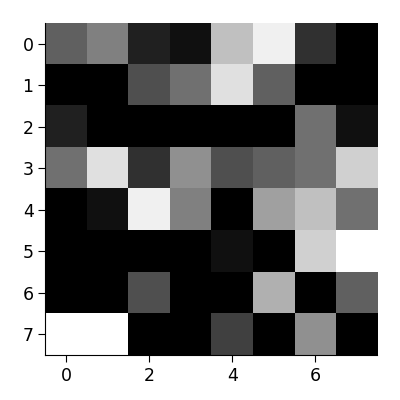

In [23]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx} + b$$
As before, $b$ is the (scalar) bias, or baseline activation level of the output neuron and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could aslo be thought of as a row vector.)  As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Recall that $\sigma(y): \frac{1}{1+e^{-y}} = \frac{e^y}{1+e^y}$ is the standard logistic (sigmoid) function.

In [24]:
def eval_params_rich(W, b, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    b: (scalar) bias of behavioural output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) + b # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

In [25]:
eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

1.4359891754087805e-28

In [26]:
%timeit eval_params_rich(np.ones((1,64)), 0, Xs.T, y1.T)

358 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


That's working and relatively quick now let's adapt our learning loop for this new setup.

In [27]:
# @title Measure and Update Training Loop

learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
W_init = np.zeros((1,64))
b_init = 0
W = W_init
b = b_init
start_time = time.time()
for ii in range(num_learning_episodes+1):
  R_bar_old = eval_params_rich(W, b, Xs.T, y1.T)
  # get pertubations for W all at once
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,64))
  #perturb and evaluate each W_j seperately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    W_perturbed = np.copy(W)
    W_perturbed[0,j] += W_perturbations[0,j]
    R_bar_perturbed_Wj = eval_params_rich(W_perturbed, b, Xs.T, y1.T)
    finite_difference_Wj = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,j]
    finite_differences_W[0,j] = finite_difference_Wj
  # perturb b and evaluate
  b_perturbation = learn_rng.normal(0, perturbation_scale)
  b_perturbed = b + b_perturbation
  R_bar_perturbed_b = eval_params_rich(W, b_perturbed, Xs.T, y1.T)
  # estimate rate of change of reward for each parameter
  finite_difference_b = (R_bar_perturbed_b - R_bar_old) / b_perturbation
  # update parameters based on finte difference estimate rate of change
  # of reward with respect to parameters
  delta_W = alpha * finite_differences_W
  delta_b = alpha * finite_difference_b
  W += delta_W
  b += delta_b

  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={b:<8.4f} | {"R_bar":>5}={R_bar_old:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

   Iteration: 0      | W_0=0.1041   | b=0.0008   | R_bar=0.003381 | Time=0.02  seconds
   Iteration: 100    | W_0=0.1621   | b=-0.0103  | R_bar=0.425334 | Time=2.33  seconds
   Iteration: 200    | W_0=0.1680   | b=-0.0147  | R_bar=0.430483 | Time=4.88  seconds
   Iteration: 300    | W_0=0.1803   | b=-0.0191  | R_bar=0.433381 | Time=7.92  seconds
   Iteration: 400    | W_0=0.1900   | b=-0.0221  | R_bar=0.434753 | Time=10.24 seconds
   Iteration: 500    | W_0=0.1991   | b=-0.0246  | R_bar=0.435717 | Time=13.47 seconds
   Iteration: 600    | W_0=0.2072   | b=-0.0266  | R_bar=0.436449 | Time=17.17 seconds
   Iteration: 700    | W_0=0.2148   | b=-0.0283  | R_bar=0.437030 | Time=21.84 seconds
   Iteration: 800    | W_0=0.2224   | b=-0.0298  | R_bar=0.437506 | Time=25.69 seconds
   Iteration: 900    | W_0=0.2301   | b=-0.0311  | R_bar=0.437906 | Time=29.18 seconds
   Iteration: 1000   | W_0=0.2379   | b=-0.0323  | R_bar=0.438249 | Time=31.66 seconds
   Iteration: 1100   | W_0=0.2458   | b=-0.

So it looks like this is learning to do an okay job. A quick inspection of the data tells us that doing perfect discrimination would give an average score of 0.503... per round.



In [28]:
# There are this many cases where striking is the right thing to do
np.sum(y1 == 1)

2829

In [29]:
# And this many cases where striking is the wrong thing to do
np.sum(y1 == 0)

2791

In [30]:
# So this the average score per round with perfect discrimination
np.sum(y1 == 1) / (len(y1))

0.5033807829181495

Without benchmarks it's hard to know what level is possible given this particular data set/discrimination task, and this particular sensory-behaviour circuit. I.e. is it the problem and the the circuit archetecture (in ML the model) or is it the learning algorithm that is holding us back? We could always let the above learning process run for a really long time and see where it stops, but who wants to wait around for results, not us. So let's see if we can come up with some faster learning processes for this sensory-behaviour circuit.

In [31]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.1.3: Learning to Do The Right Thing - Faster

In our simple problem 'propose and reject' was quite effective, let's see how it fares in this more complex problem. First though, to make our programing and notation a little cleaner we are going 'hide' our bias term. We to do this by augmenting the features, to contain a feature that always has value '1'. Then the 'weight' from this feature that always has value '1' to the output will be equivalent to a bias term.

In [32]:
# Before augmentation this is the shape of the feature set
Xs.shape

(5620, 64)

In [33]:
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])
print(Xs_aug.shape)

(5620, 65)


In [43]:
# We need to tweak our eval_params function to work with this augmented
# feature set

def eval_params_aug(W, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(64) np.array)
       weights between sensory neurons and output neuron
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np.dot(W,x) # 1 x batch
  y_hat = np_sigmoid(h) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

This is what 'propose and reject' looks like for this harder problem:

In [35]:
# @title Propose and Reject Training Loop
learn_rng = np.random.default_rng(0)
num_learning_episodes = 2000
perturbation_scale = 0.1 # std of gaussian perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
R_bar_best = eval_params_aug(W, Xs_aug.T, y1.T)
for ii in range(num_learning_episodes+1):
  W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
  #perturb and evaluate each W_j seperately
  finite_differences_W = np.zeros(W.shape)
  for j in range(W_perturbations.shape[1]):
    #perturb W
    W[0,j] += W_perturbations[0,j]
    R_bar_perturbed = eval_params_aug(W, Xs_aug.T, y1.T)
    if R_bar_perturbed > R_bar_best:
      # leave the perturbation in place and update the best
      R_bar_best = R_bar_perturbed
    else:
      #undo the perturbation
      W[0,j] -= W_perturbations[0,j]
  if ii == 0 or ii % 100 == 0:
    elapsed_time = time.time() - start_time
    print(f'{"Iteration":>12}: {ii:<6} | {"W_0":>1}={W[0,0]:<8.4f} | {"b":>1}={W[0,-1]:<8.4f} | {"R_bar":>5}={R_bar_best:<8.6f} | {"Time":>4}={elapsed_time:<5.2f} seconds')

   Iteration: 0      | W_0=0.0126   | b=0.0000   | R_bar=0.203890 | Time=0.04  seconds
   Iteration: 100    | W_0=0.2405   | b=-0.3796  | R_bar=0.435554 | Time=3.20  seconds
   Iteration: 200    | W_0=0.2774   | b=-0.5088  | R_bar=0.437951 | Time=5.43  seconds
   Iteration: 300    | W_0=0.3170   | b=-0.7997  | R_bar=0.439129 | Time=7.62  seconds
   Iteration: 400    | W_0=0.3589   | b=-1.0423  | R_bar=0.439855 | Time=9.85  seconds
   Iteration: 500    | W_0=0.3789   | b=-1.1784  | R_bar=0.440282 | Time=12.08 seconds
   Iteration: 600    | W_0=0.4278   | b=-1.2118  | R_bar=0.440657 | Time=14.92 seconds
   Iteration: 700    | W_0=0.4436   | b=-1.2546  | R_bar=0.440974 | Time=17.69 seconds
   Iteration: 800    | W_0=0.4752   | b=-1.3299  | R_bar=0.441181 | Time=19.94 seconds
   Iteration: 900    | W_0=0.5016   | b=-1.5042  | R_bar=0.441429 | Time=22.13 seconds
   Iteration: 1000   | W_0=0.5436   | b=-1.6193  | R_bar=0.441608 | Time=24.37 seconds
   Iteration: 1100   | W_0=0.5660   | b=-1.

So this 'propose and reject' method was faster, in that although it took as long per iteration, the iterations got to a higher `R_bar` more quickly. Again we could run this for a long time and see where improvement really caps out.

One important idea for speeding up learning is the idea of a 'mini-batch'. Currently in our learning the impact on reward for a perturbation is measured using the entirety of the data set available to us. If we were to use a smaller (but representative) sample of this data set for our evaluations of the parameter perturbations we could potentially speed things up a lot.

In [36]:
Xs_aug.shape

(5620, 65)

Our data set consists of 5620 examples to learn from. This can be nicely broken down into 10 mini-batches of 562. How much faster is our evaluation function when we use a mini-batch which is ten times smaller?


In [37]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

143 µs ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
%timeit eval_params_aug(W, Xs_aug.T, y1.T)

345 µs ± 73.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So a 2-3 times speed up. One thing to notice, is that this was not a 10x speedup. This is because in our heavily optimized evaluation function (utiliszing numpy broadcasting) there are a lot of 'algorithmic efficiencies of scale' being utilized. These efficiencies of scale are tied to underlying hardware implementations of the operations. Thus in practical ML contexts choosing a 'good' mini-batch size requires consideration hardware specific effciencies of scale, to answer the question how much worse are my parameter updates versus how much faster are they.

In [39]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 800
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 10  # Number of mini-batches
batch_size = 562  # Size of each mini-batch
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_aug(W, Xs_batch, y1_batch)
    W_perturbations = learn_rng.normal(0, perturbation_scale, size=(1,65))
    #perturb and evaluate each W_j seperately
    finite_differences_W = np.zeros(W.shape)
    for jj in range(W_perturbations.shape[1]):
      original_value = W[0,jj]
      W[0, jj] += W_perturbations[0, jj]
      R_bar_perturbed_Wj = eval_params_aug(W, Xs_batch, y1_batch)
      finite_differences_W[0,jj] = (R_bar_perturbed_Wj - R_bar_old) / W_perturbations[0,jj]
      W[0,jj] = original_value  # Revert the perturbation

    delta_W = alpha * finite_differences_W
    W += delta_W

  if epoch == 0 or (epoch + 1) % 50 == 0:
    R_bar_full_batch = eval_params_aug(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Epoch 1/800 completed | Full Batch R_bar: 0.379098 | Time elapsed: 0.06 seconds
Epoch 50/800 completed | Full Batch R_bar: 0.434961 | Time elapsed: 3.37 seconds
Epoch 100/800 completed | Full Batch R_bar: 0.438279 | Time elapsed: 6.56 seconds
Epoch 150/800 completed | Full Batch R_bar: 0.438686 | Time elapsed: 10.77 seconds
Epoch 200/800 completed | Full Batch R_bar: 0.440117 | Time elapsed: 14.20 seconds
Epoch 250/800 completed | Full Batch R_bar: 0.441061 | Time elapsed: 17.14 seconds
Epoch 300/800 completed | Full Batch R_bar: 0.441562 | Time elapsed: 20.89 seconds
Epoch 350/800 completed | Full Batch R_bar: 0.441167 | Time elapsed: 24.23 seconds
Epoch 400/800 completed | Full Batch R_bar: 0.442362 | Time elapsed: 27.11 seconds
Epoch 450/800 completed | Full Batch R_bar: 0.442165 | Time elapsed: 30.90 seconds
Epoch 500/800 completed | Full Batch R_bar: 0.442647 | Time elapsed: 34.66 seconds
Epoch 550/800 completed | Full Batch R_bar: 0.443151 | Time elapsed: 38.72 seconds
Epoch 600/

Okay so apply the mini-batch idea to 'measure and update' helped make it quicker, maybe even performing a bit better than 'propose and reject', though such comparisons are fraught due to performance being so dependent on meta-parameter choices (e.g. learning rate, perturbation scale, mini-batch size, etc.).

In [40]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 2.1.1.4 Learning to Do The Right Thing - Better - Stronger
So one thing that could be holding back performance on this discrimination problem is that our algorithms are not capable of finding the optimal parameters for the given model, but... we don't really think that is the case here. Another possibility is that our simple sensory-behaviour circuit is not flexible/complex enough to fully discriminate between the two types of input. There is good reason to think that this might be the case. Our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each feature can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By conditional interaction we mean allowing for the possibility that feature 1 is typically inhibitory of the behaviour, except, when feature 2 is positive, in which case feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(65^2 - 1) = 4224$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable. If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and label could might be able to cherry pick some small subset of higher order interaction terms, but the ML/supervised learning framework is in large part about automating the feature selection processes based on the data alone. In turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons. In mathematical terms we mean precisely this.



As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 20 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \cdot \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons, and $\cdot$ is is usual matrix vector multiplication. (In this case $\mathbf{W}$ has shape 20x64. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strenght of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in these case applied elementwise the vector output of the product $\mathbf{W}_{in} \cdot \mathbf{x}$. Then much as before our striking probability is computed as
$$y = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$
Here $\mathbf{W}_{out}$ has shape 1x20.


We will need to write a new eval params function for this new model, let's do it.

In [44]:
def eval_params_hidden(W_in, W_out, x, y):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden-neurons(20) x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden-neurons(20) np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_bar: the average/expected reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  h = np_sigmoid(np.dot(W_in,x)) # hidden x batch
  y_hat = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  y_score = np.copy(y)
  y_score[y_score == 0] = -1
  batch_expected_reward = y_score * y_hat
  R_bar = np.mean(batch_expected_reward)
  return R_bar

We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate?

In [45]:
W = np.zeros((1,65))
%timeit eval_params_aug(W, Xs_aug[:562,:].T, y1[:562].T)

131 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [46]:
W_in = np.zeros((20,65))
W_out = np.zeros((1,20))
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:562,:].T, y1[:562].T)

431 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We're added a lot more operations here, and now our senory to behaviour function takes about 4x times longer to evaluate. What if we made our minibatch really small, like 20, so that we had 261 mini-batches each of size 20, how much of a speed up does that give us?

In [47]:
%timeit eval_params_hidden(W_in, W_out, Xs_aug[:20,:].T, y1[:20].T)

45.8 µs ± 498 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Okay that's starting to be pretty quick again, but we have a lot more parameters to evaluate, 1320, as contrasted with 65 from our more simple circuit? Can the mini-batched measure and update training loop, find good parameters is reasonable amount of time?

In [57]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 20
alpha = 0.5 #learning rate or step size
perturbation_scale = 0.001 # std of gaussian perturbations
num_batches = 261  # Number of mini-batches
batch_size = 20  # Size of each mini-batch
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + 20))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(20, 65))
out_init = np.sqrt(6 / (20 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, 20))
W_in = W_in_init
W_out = W_out_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch)
    W_in_perturbations = learn_rng.normal(0, perturbation_scale, size=W_in.shape)
    W_out_perturbations = learn_rng.normal(0, perturbation_scale, size=W_out.shape)
    #perturb and evaluate each parameter seperately
    finite_differences_W_in = np.zeros(W_in.shape)
    for ii in range(W_in_perturbations.shape[0]):
      for jj in range(W_in_perturbations.shape[1]):
        original_value = W_in[ii,jj]
        W_in[ii,jj] += W_in_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_in[ii,jj] = (R_bar_perturbed - R_bar_old) / W_in_perturbations[ii,jj]
        W_in[ii,jj] = original_value  # Revert the perturbation
    finite_differences_W_out = np.zeros(W_out.shape)
    for ii in range(W_out_perturbations.shape[0]):
      for jj in range(W_out_perturbations.shape[1]):
        original_value = W_out[ii,jj]
        W_out[ii,jj] += W_out_perturbations[ii,jj] # perturb
        R_bar_perturbed = eval_params_hidden(W_in, W_out, Xs_batch, y1_batch) #evaluate
        finite_differences_W_out[ii,jj] = (R_bar_perturbed - R_bar_old) / W_out_perturbations[ii,jj]
        W_out[ii,jj] = original_value  # Revert the perturbation

    delta_W_in = alpha * finite_differences_W_in
    W_in += delta_W_in
    delta_W_out = alpha * finite_differences_W_out
    W_out += delta_W_out

  R_bar_full_batch = eval_params_hidden(W_in, W_out, Xs_aug.T, y1.T)
  elapsed_time = time.time() - start_time
  print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')

Epoch 1/20 completed | Full Batch R_bar: 0.426938 | Time elapsed: 16.03 seconds
Epoch 2/20 completed | Full Batch R_bar: 0.450755 | Time elapsed: 32.07 seconds
Epoch 3/20 completed | Full Batch R_bar: 0.464185 | Time elapsed: 48.16 seconds
Epoch 4/20 completed | Full Batch R_bar: 0.461140 | Time elapsed: 64.19 seconds
Epoch 5/20 completed | Full Batch R_bar: 0.476647 | Time elapsed: 80.34 seconds
Epoch 6/20 completed | Full Batch R_bar: 0.482166 | Time elapsed: 96.36 seconds
Epoch 7/20 completed | Full Batch R_bar: 0.481275 | Time elapsed: 112.50 seconds
Epoch 8/20 completed | Full Batch R_bar: 0.485875 | Time elapsed: 128.63 seconds
Epoch 9/20 completed | Full Batch R_bar: 0.488056 | Time elapsed: 144.90 seconds
Epoch 10/20 completed | Full Batch R_bar: 0.488805 | Time elapsed: 161.50 seconds
Epoch 11/20 completed | Full Batch R_bar: 0.489433 | Time elapsed: 178.03 seconds
Epoch 12/20 completed | Full Batch R_bar: 0.490547 | Time elapsed: 194.28 seconds
Epoch 13/20 completed | Full Ba

So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 0.5033807829181495, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination.

In [48]:
20 * 66

1320

# Save for later

In [ ]:
# @title Mini-Batched Measure and Update Training Loop
learn_rng = np.random.default_rng(0)
num_epochs = 1000  # Number of passes over the entire dataset
# relationship between number of batches and batch size depends on size of the data set
num_batches = 20  # Number of mini-batches
batch_size = 281  # Size of each mini-batch
num_perturbuations = 66 # needs to be greater than number of parameters for this approach
alpha = 0.05  # Learning rate or step size
perturbation_scale = 0.00001  # std of Gaussian perturbations
W_init = np.zeros((1,65))
W = W_init

start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  learn_rng.shuffle(indices)  # Shuffle the indices for each epoch
  for batch in range(num_batches):
    # Select a mini-batch for this iteration
    batch_indices = indices[batch * batch_size : (batch + 1) * batch_size]
    Xs_batch = Xs_aug[batch_indices, :].T
    y1_batch = y1[batch_indices].T
    R_bar_old = eval_params_aug(W, Xs_batch, y1_batch)
    # Store data from perturbations here
    perturbations = np.zeros((num_differences, 65))
    test_R_bar_values = np.zeros(num_differences)

    for jj in range(num_differences):
      W_perturbation = learn_rng.normal(0, perturbation_scale, size=(1,65))
      W_perturbed = W + W_perturbation
      # Evaluate the perturbation
      R_bar_perturbed = eval_params_aug(W_perturbed, Xs_batch, y1_batch)
      perturbations[jj, :] = W_perturbation.squeeze()
      test_R_bar_values[jj] = R_bar_perturbed - R_bar_old

    # Perform linear regression to estimate how R_bar changes with underlying parameter changes
    XTX = np.dot(perturbations.T, perturbations)
    XTy = np.dot(perturbations.T, test_R_bar_values)
    change_R_bar_by_change_parameters_estimate = np.linalg.solve(XTX, XTy)

    # Update the parameters based on this estimate
    delta_W = alpha * change_R_bar_by_change_parameters_estimate
    W += delta_W

  # Print progress at the end of each epoch
  if epoch == 0 or (epoch + 1) % 40 == 0:
    R_bar_full_batch = eval_params_aug(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} completed | Full Batch R_bar: {R_bar_full_batch:.6f} | Time elapsed: {elapsed_time:.2f} seconds')


In a given learning episode one of four cases can occur:

1. Prey is present, given the sensory input the organisms strikes, a positive reward is obtained
2. Prey is not present, given the sensory input the organism strikes, a negative reward is obtained
3. Prey is present, given the sensory input the organism does not strike, no reward is obtained
4. Prey is not present, given the sensory input the organism does not strike, no reward is obtained

We have the (initial) caveat that from the perspective of the organisms cases 3 and 4 are identical, so the parameter update rule must also be identical in each of those cases.

It has been noted and proposed many times that the inherent stochasticity of synaptic firing might provide a kind of natural 'guess' and allow for this kind of learning to be implemented in the brain, [citations]. Empirical evidence for this kind of learning is also begining to accumulate [citations].

The basic idea is as follows. Due to the stochastic spiking of neurons, in any given episode of senosry input -> behaviour production -> contingent reward, some but not all of the synaptic weights are causally implicated in the production of the behaviour (and consequent reward). When a good thing happens, synaptic connections that were involved in the generation of the behaviour should be strengthened, and conversely when bad things happen synaptic connections that were involved in the generation of the behaviour should be weakened. Synaptic connections that were not involved in producing the behaviour should be left unchanged. Zooming in to the synaptic level the four cases above are expanded as follows:

1. Both input and output neurons spike, a good thing happens
2. Both input and output neurons spike, a bad thing happens
3. Input neuron spikes but output neuron doesn't spike, a neutral thing happens
4. Input neuron doesn't spike, output neuron spikes, a good thing happens
5. Input neuron doesn't spike, output neuron spikes, a bad thing happens
6. Neither input nor output neuron spikes, a neutral thing happens.

In this our first and most simple (from a physiological mechanism perspective, actually a bit complicated from a mathematical description perspective), only in the first two cases, when both the pre- and post- synaptic neurons fire, is the synapse causally implicated in the reward outcome. So our rule needs to prescribe no change, unless both pre- and post- synaptic neurons have fired. If a good thing happens, then the connection should be reinforced, and if a bad thing happens then the connection should be weakened. Our learning rule written to echo and presiage the 'REINFORCE' formulation of Williams (1992), and also Resrola Wagnar rule, and also TD formulations. In some sense this is cannonical form of learning rules is.

$$\Delta w_i = \alpha \cdot (r - b) \cdot s_i \cdot s_o$$

Almost every learning rule for parameters that we look at will be roughly composed of these three factors: learning rate, error, eligibility. The first factor is positive learning rate or step size parameter of the learning process. In this specific case $\alpha$ is constant, but it could be made contingent on various factors in more complicated models, e.g. learning rates often start high and are lowered as the learning system gets more 'dialed in'. The second part is an 'error' term, in this case a 'reward prediction error', $(r-b)$, gives the way in which the actual received reward $r$ differs from some baseline expectation. Again in more complicated learning rules $b$ could be made contingent on many factors, and this contingency of $b$ on other factors might itself be learned. Here though, we assume a constant expected reward, $b=0$, so we can think of $b$ as an expectation of how good the world is on average, if the organism is performing as well as expected. We imagine that parameters like $\alpha$ and $b$ are set and tuned by evolution to ensure effective learning. Lastly, in this simple model the $s_i \cdot s_o$ term is the 'eligibility' of the synapse for change. In general, this will be some measure of how causally implicated the particular parameter $w_i$ is in causing the received reward. Here we use one of the simplest possible eligibility terms, which takes the value one only when both pre- and post- synaptic neurons fire, and is otherwise zero. Again in more complicated learning rules, this eligibility term could be more complicated, e.g. it might incorporate knowledge of the structure of the network producing the behaviour, often in the form of a gradient, to further modulate the strength and direction of the weight change. Note, $w_i$ is the $i^{\text{th}}$ element of $\mathbf{W}$ and $s_i$ and $s_o$ are the realized spikes during the episode for the $i^{\text{th}}$ input neuron and the output neuron respectively. Okay, let's implement and see how well this works!

We model this creature's sensory-behaviour system as follows. Let $\mathbf{x}$ be the raw sensory input vector in a given episode. We imagine that each element of $\mathbf{x}$, denoted $x_i$ corresponds to the activation level of a single photosensitive neuron. These activation levels might be losely interpreted as firing rates. This input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$y = \mathbf{Wx}$$
Here, $\mathbf{W}$ is the matrix of synaptic weights between the input neurons and the output neuron (is this case there is only one output so $\mathbf{W}$ is effectively a row vector). As a quick reminder, in our notation, bold lowercase letters represent column vectors, while bold uppercase letters denote matrices or higher-dimensional tensors. We imagine that the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(y) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(y)$$

Here $\sigma(x): \frac{1}{1+e^{-x}} = \frac{e^x}{1+e^x}$ is the standard logistic (sigmoid) function.

In [ ]:


def learning_episode(W, x, target, rng, alpha=0.01, b=0, ):
  #forward pass, generate behaviour
  sensory_nueron_spike_probs = np_sigmoid(x)
  sensory_neuron_spikes = rng.binomial(1, sensory_nueron_spike_probs)
  output_neuron_activation = np.dot(W, sensory_neuron_spikes)
  output_neuron_spike_prob = np_sigmoid(output_neuron_activation)
  output_neuron_spike = rng.binomial(1, output_neuron_spike_prob)
  #evaluate behaviour
  reward = output_neuron_spike * target
  # backward pass,update parameters
  W += alpha * (reward - b) * output_neuron_spike * sensory_neuron_spikes
  return W, reward, output_neuron_spike, output_neuron_spike_prob

In [ ]:
# Now embedd those learning episodes in a training loop
# pre calculate activation to probability for efficiency
train_rng = np.random.default_rng(1234)
W = train_rng.standard_normal(size=(1, Xs.shape[1]))

epochs = 500  # Number of times to iterate over the dataset
performance_tracker = {'cumulative_reward': [], 'accuracy': [],
                       'TP':[], 'FP':[], 'TN':[], 'FN':[],}
max_possible_reward = np.sum(y1==1)
alpha=0.00001
b=0
pbar = tqdm(range(epochs), desc='Training Progress')
for epoch in pbar:
  cumulative_reward = 0
  TP, FP, TN, FN = 0, 0, 0, 0
  shuffled_indices = train_rng.permutation(Xs.shape[0])
  for i in shuffled_indices:  # Iterate over each example
    x = Xs[i]
    target = y1[i]
    W, reward, output_neuron_spike, _ = learning_episode(W, x, target,
                                                         train_rng, alpha, b)
    # Track performance
    cumulative_reward += reward
    # Update confusion matrix
    if output_neuron_spike == 1 and target == 1:
      TP += 1
    elif output_neuron_spike == 1 and target == -1:
      FP += 1
    elif output_neuron_spike == 0 and target == 1:
      FN += 1
    elif output_neuron_spike == 0 and target == -1:
      TN += 1
  epoch_accuracy = (TP + TN) / Xs.shape[0]
  performance_tracker['cumulative_reward'].append(cumulative_reward)
  performance_tracker['accuracy'].append(epoch_accuracy)
  # Store confusion matrix values
  performance_tracker.setdefault('TP', []).append(TP)
  performance_tracker.setdefault('FP', []).append(FP)
  performance_tracker.setdefault('TN', []).append(TN)
  performance_tracker.setdefault('FN', []).append(FN)
  pbar.set_postfix({
        'Acc': f'{epoch_accuracy:.4f}',
        'Cum. Reward': cumulative_reward/max_possible_reward,
        'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN
    })

In [ ]:
# if we visualize the features do they look like anything?
plt.imshow(Xs[0,:].reshape(8,8), cmap='gray')
plt.show()

In [ ]:
# Plot cumulative reward
plt.subplot(1, 2, 1)
plt.plot(performance_tracker['cumulative_reward']/max_possible_reward)
plt.title('Normalized Cumulative Reward Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cumulative Reward')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(performance_tracker['accuracy'])
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
plt.hist(W.flatten())
plt.show()

In [ ]:
scramble_full_imp = InteractiveMNISTPredator(just_01=False)
display(scramble_full_imp.fig.canvas)
clear_output()
display(scramble_full_imp.ui)

**Coding Exercise: Implement minimal trial and error learning.**

On each learning round $t$ each individual who has yet to experience variable payoffs tries a new neural parameter configuration distributed as $g'(t)$ above, and receives a resulting score $z(g'(t))$. Additionally each round some proportion of the target $y$ is subject to change with some fixed probability. Let's adapt our evolutionary simulation function from the previous sequences to implement this simple form of learning and environmental change:

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")